In [1]:
#pip install pydiffmap

In [2]:
import os
import io

In [3]:

print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/daiziheng/Desktop/445 Project


In [4]:

directory_path = '/Users/daiziheng/Desktop/445 Project/ScienceNews'  # Change this to the actual path

# List to hold the contents of each document
documents = []

# Function to check if the filename is numeric
def is_numeric(filename):
    try:
        int(filename)
        return True
    except ValueError:
        return False

# Loop through each file in the directory
# Only process files that have fully numeric names
for filename in sorted(filter(is_numeric, os.listdir(directory_path)), key=int):
    file_path = os.path.join(directory_path, filename)
    #with io.open(file_path, 'r', encoding='utf8') as file:
        #documents.append(file.read())
    with io.open(file_path, 'r', encoding='utf8', errors='ignore') as file:
        documents.append(file.read())

print("Loaded {} documents.".format(len(documents)))




Loaded 1160 documents.


In [5]:
import pandas as pd

# Load labels
labels_path = '/Users/daiziheng/Desktop/445 Project/Labels.txt'
labels_df = pd.read_csv(labels_path, delim_whitespace=True, header=None, names=['doc_id', 'label'])


# Create a dictionary of labels keyed by document ID
label_dict = dict(zip(labels_df['doc_id'], labels_df['label']))

# Create a list of labels that matches the order of document vectors
document_ids = [int(doc.split('.')[0]) for doc in sorted(os.listdir('/Users/daiziheng/Desktop/445 Project/ScienceNews')) if doc.isdigit()]
true_labels = [label_dict[doc_id] for doc_id in document_ids if doc_id in label_dict]

print("Labels loaded and aligned with document order.")
len(true_labels)

Labels loaded and aligned with document order.


1047

In [6]:

directory_path = '/Users/daiziheng/Desktop/445 Project/ScienceNews'

# Get all document IDs from filenames
document_ids_from_files = sorted([int(filename) for filename in os.listdir(directory_path) if filename.isdigit()])

# Load labels
labels_path = '/Users/daiziheng/Desktop/445 Project/Labels.txt'
labels_df = pd.read_csv(labels_path, delim_whitespace=True, header=None, names=['doc_id', 'label'])

# Get all document IDs from labels file
document_ids_from_labels = sorted(labels_df['doc_id'].tolist())

# Find missing documents in labels
missing_in_labels = set(document_ids_from_files) - set(document_ids_from_labels)
missing_in_files = set(document_ids_from_labels) - set(document_ids_from_files)

print("Documents in files but missing labels:", missing_in_labels)
print("Labels present but missing documents in files:", missing_in_files)


Documents in files but missing labels: {10242, 10255, 10257, 10261, 10263, 10264, 10781, 10270, 10783, 10275, 10800, 10292, 10806, 10299, 10812, 10815, 10816, 10820, 10311, 10831, 10329, 10845, 10851, 10357, 10875, 10365, 10891, 10387, 10902, 10396, 10909, 10407, 10413, 10417, 10940, 10432, 10945, 10440, 10446, 10449, 10450, 10963, 10964, 10967, 10458, 10459, 10477, 10989, 10994, 10536, 10040, 11068, 10044, 10560, 10561, 10048, 10057, 10578, 11091, 10068, 10079, 10081, 10082, 10084, 10597, 10089, 11117, 10097, 11124, 10104, 11130, 11132, 11134, 10112, 11139, 10633, 11146, 10129, 10642, 10132, 11158, 11159, 10648, 11160, 10652, 10140, 10659, 10660, 10147, 10669, 10674, 10168, 10169, 10174, 10177, 10179, 10692, 10182, 10698, 10705, 10714, 10205, 10207, 10721, 10209, 10211, 10212, 10215, 10744, 10746, 10235, 10237, 10751}
Labels present but missing documents in files: set()


In [7]:
# Load only the documents that have corresponding labels
documents = []
true_labels = []

for doc_id in document_ids_from_files:
    if doc_id in document_ids_from_labels:
        file_path = os.path.join(directory_path, str(doc_id))
        with io.open(file_path, 'r', encoding='utf8', errors='ignore') as file:
            documents.append(file.read())
            true_labels.append(label_dict[doc_id])

print("Loaded {} documents.".format(len(documents)))
print("Loaded {} labels.".format(len(true_labels)))

Loaded 1047 documents.
Loaded 1047 labels.


In [8]:
# Verify that the number of documents matches the number of labels
assert len(documents) == len(true_labels), "The number of documents must match the number of labels."

print("All documents have corresponding labels.")


All documents have corresponding labels.


In [9]:
import re

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove all non-word characters (everything except numbers and letters)
    text = re.sub(r'\W+', ' ', text)
    # Replace all white space with one space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


# Apply preprocessing to each document
documents = [preprocess(doc) for doc in documents]


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer with suitable parameters
vectorizer = CountVectorizer(stop_words='english', min_df=3, max_df=0.5)  # ignoring words too common or too rare
X = vectorizer.fit_transform(documents)  


In [11]:
import numpy as np

# Convert count matrix to probability matrix
probabilities = X.toarray() / X.toarray().sum(axis=0)


# Calculate entropy for each word
entropies = -np.nansum(probabilities * np.log(probabilities + 1e-10), axis=0)  # adding small number to avoid log(0)


In [12]:
threshold = np.median(entropies)  # Using median as a threshold
important_indices = entropies < threshold  # Filter indices where entropy is below the threshold
X_filtered = X[:, important_indices]  # Filter columns in original matrix

In [13]:
from sklearn.preprocessing import normalize

# Normalize using L1 norm
X_normalized_l1 = normalize(X_filtered, norm='l1')

# Normalize using L2 norm
X_normalized_l2 = normalize(X_filtered, norm='l2')


In [14]:
X_normalized_l1

<1047x8024 sparse matrix of type '<class 'numpy.float64'>'
	with 36232 stored elements in Compressed Sparse Row format>

In [15]:
from pydiffmap import diffusion_map as dm
import numpy as np
from sklearn.neighbors import kneighbors_graph

# Assuming X_normalized is your preprocessed document-term matrix
#neighbor_params = {'n_neighbors': 10, 'algorithm': 'auto', 'n_jobs': -1}
#mydmap = dm.DiffusionMap.from_sklearn(n_evecs=2, epsilon='bgh', alpha=1.0, neighbor_params=neighbor_params)
#X_embedded = mydmap.fit_transform(X_normalized_l1)

In [18]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import normalize


In [19]:
from pydiffmap import diffusion_map as dm
import numpy as np


In [20]:
from pydiffmap import diffusion_map as dm

help(dm.DiffusionMap)


Help on class DiffusionMap in module pydiffmap.diffusion_map:

class DiffusionMap(builtins.object)
 |  DiffusionMap(kernel_object, alpha=0.5, n_evecs=1, weight_fxn=None, density_fxn=None, bandwidth_normalize=False, oos='nystroem')
 |  
 |  Diffusion Map object for data analysis
 |  
 |  Parameters
 |  ----------
 |  kernel_object : Kernel object.
 |      Kernel object that outputs the values of the kernel.  Must have the method .fit(X) and .compute() methods.
 |      Any epsilon desired for normalization should be stored at kernel_object.epsilon_fitted and any bandwidths
 |      should be located at kernel_object.bandwidths.
 |  alpha : scalar, optional
 |      Exponent to be used for the left normalization in constructing the diffusion map.
 |  n_evecs : int, optional
 |      Number of diffusion map eigenvectors to return
 |  weight_fxn : callable or None, optional
 |      Callable function that take in a point, and outputs the value of the weight matrix at those points.
 |  density_f

In [21]:
import scipy.sparse

In [22]:
import numpy as np
import scipy.sparse


if isinstance(X_normalized_l2, scipy.sparse.csr.csr_matrix):
    X_normalized_l2 = X_normalized_l2.toarray()
    
if isinstance(X_normalized_l1, scipy.sparse.csr.csr_matrix):
    X_normalized_l1 = X_normalized_l1.toarray()
    
# Ensure no NaNs or Infs in the data
if np.any(np.isnan(X_normalized_l2)) or np.any(np.isinf(X_normalized_l2)):
    raise ValueError("Data contains NaNs or infinite values, which must be cleaned before processing.")
if np.any(np.isnan(X_normalized_l1)) or np.any(np.isinf(X_normalized_l1)):
    raise ValueError("Data contains NaNs or infinite values, which must be cleaned before processing.")

from pydiffmap import diffusion_map as dm

neighbor_params = {'n_jobs': -1, 'algorithm': 'auto'} 

/var/folders/pj/z4b3jc11167gtk0sckxcr7q40000gn/T/ipykernel_36223/756470009.py:5: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if isinstance(X_normalized_l2, scipy.sparse.csr.csr_matrix):
/var/folders/pj/z4b3jc11167gtk0sckxcr7q40000gn/T/ipykernel_36223/756470009.py:8: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if isinstance(X_normalized_l1, scipy.sparse.csr.csr_matrix):


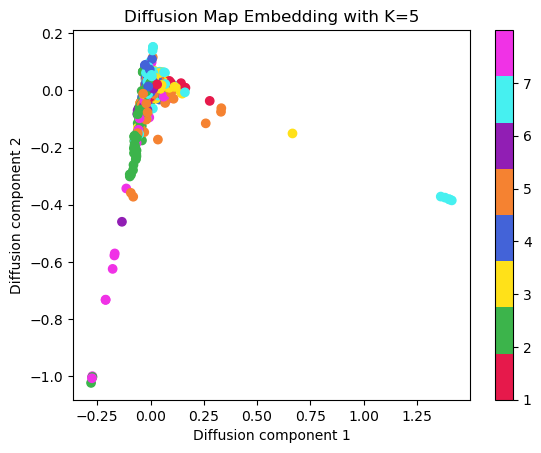

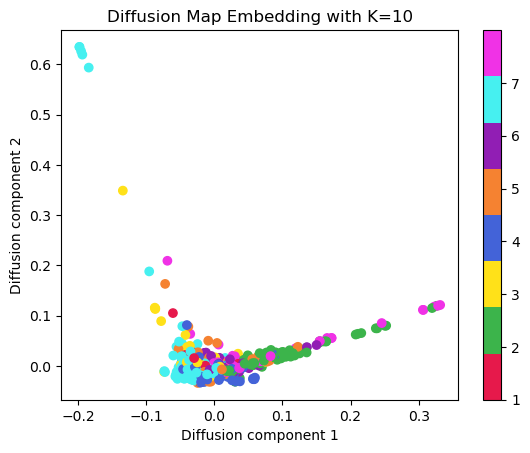

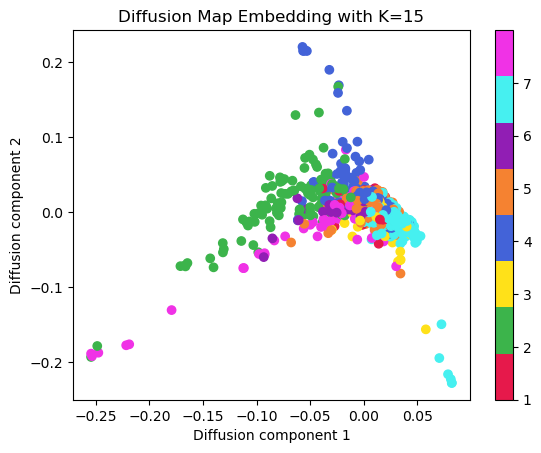

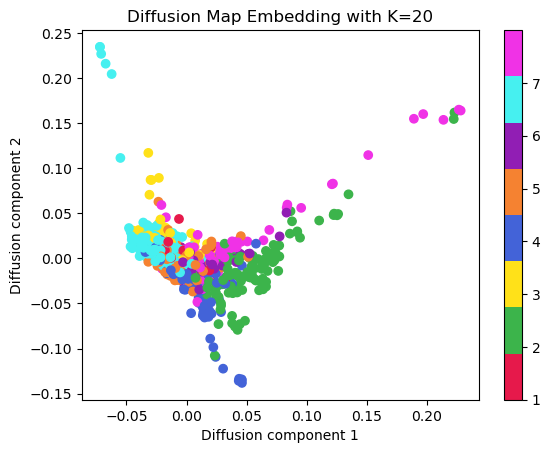

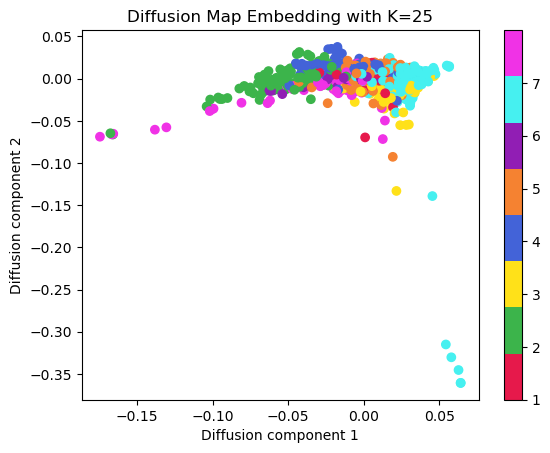

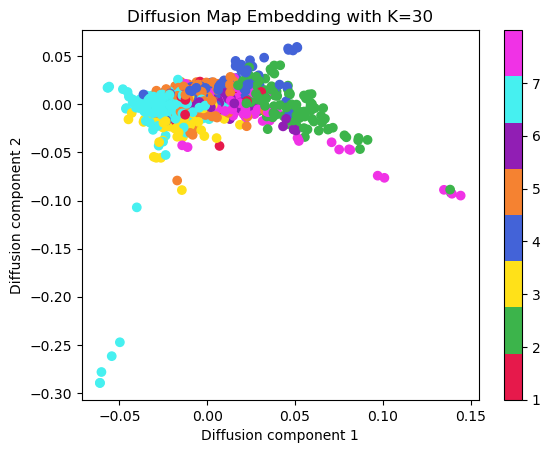

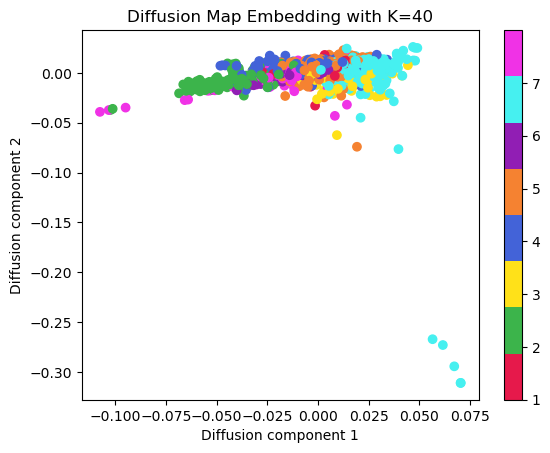

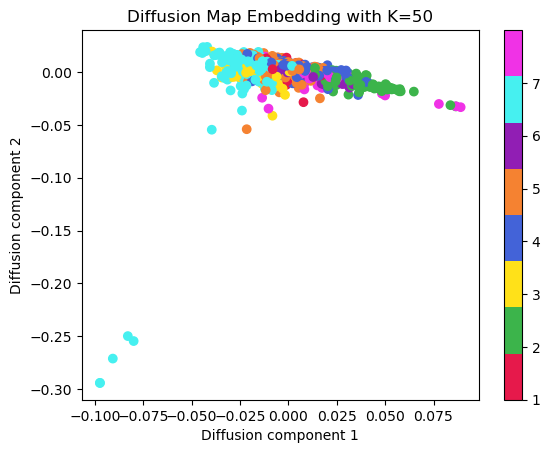

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

#cmap = plt.get_cmap('Set1', 8) 
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6']
cmap = ListedColormap(colors)

n_evecs = 2       # Number of eigenvectors to compute
alpha = 0.5  
ks = [5, 10, 15, 20, 25, 30, 40, 50]  # Different values for K 
for k in ks:
    mydmap = dm.DiffusionMap.from_sklearn(alpha=alpha, k=k, n_evecs=n_evecs, epsilon='bgh', neighbor_params=neighbor_params)
    X_embedded = mydmap.fit_transform(X_normalized_l2)

    plt.figure()
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=true_labels, cmap=cmap)
    plt.xlabel('Diffusion component 1')
    plt.ylabel('Diffusion component 2')
    plt.title('Diffusion Map Embedding with K={}'.format(k))
    plt.colorbar(scatter, ticks=np.arange(0, 8))  # Adjust colorbar to match labels
    plt.show()

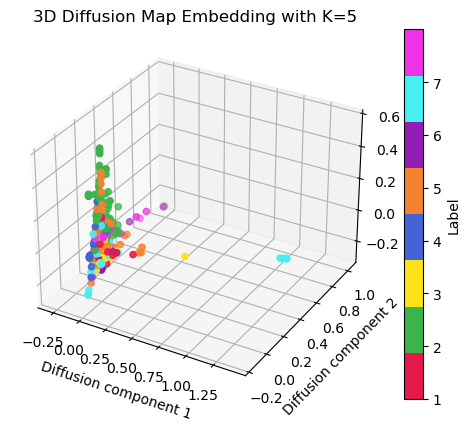

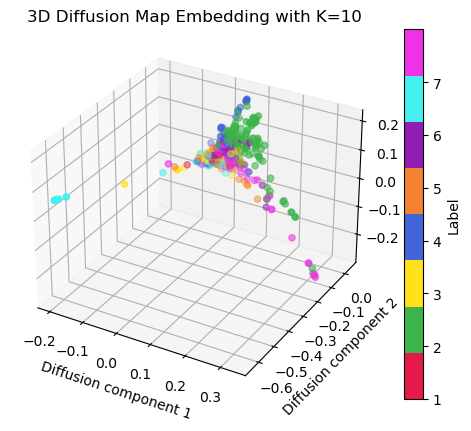

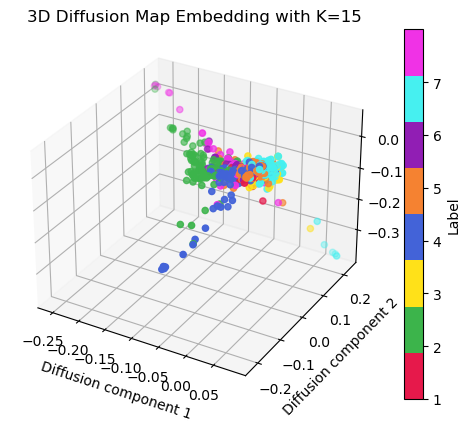

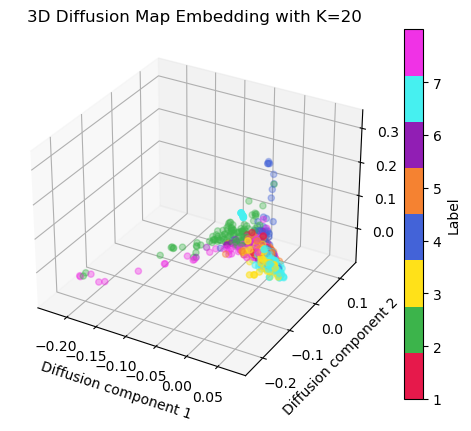

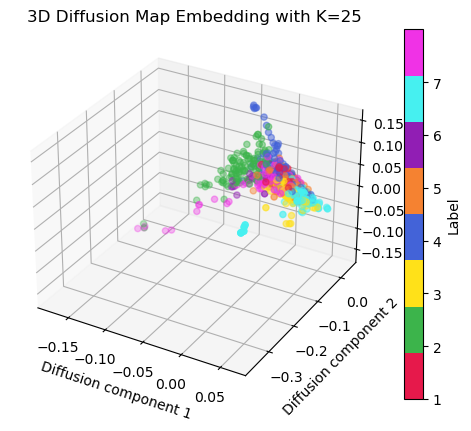

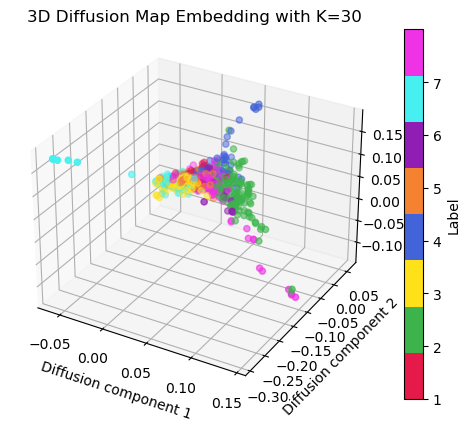

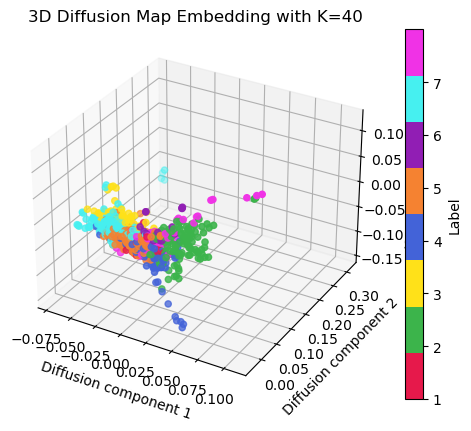

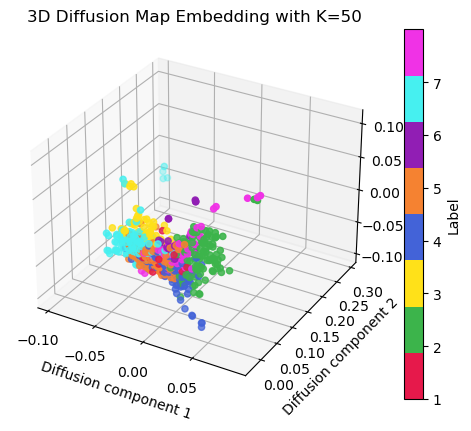

In [24]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pydiffmap import diffusion_map as dm
from matplotlib.colors import ListedColormap

# Define colors and create a colormap
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6']
cmap = ListedColormap(colors)

# Parameters for the diffusion map
n_evecs = 3      # Number of eigenvectors to compute
alpha = 0.5  
neighbor_params = {'n_jobs': -1, 'algorithm': 'auto'}  
ks = [5, 10, 15, 20, 25, 30, 40, 50]  # Different values for K 

for k in ks:
    # Ensure you're requesting three eigenvectors
    mydmap = dm.DiffusionMap.from_sklearn(alpha=alpha, k=k, n_evecs=n_evecs, epsilon='bgh', neighbor_params=neighbor_params)
    X_embedded = mydmap.fit_transform(X_normalized_l2)

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot
    scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=true_labels, cmap=cmap)
    
    ax.set_xlabel('Diffusion component 1')
    ax.set_ylabel('Diffusion component 2')
    ax.set_zlabel('Diffusion component 3')
    plt.title('3D Diffusion Map Embedding with K={}'.format(k))
    
    # Adjust colorbar to match labels
    cbar = plt.colorbar(scatter, ax=ax, ticks=np.arange(0, 8))
    cbar.set_label('Label')
    plt.show()


In [25]:
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans

# Using Spectral Embedding (Laplacian Eigenmaps) for dimensionality reduction
#embedding = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=10)
#X_embedded = embedding.fit_transform(X_normalized_l1)


In [26]:
def clean_embedding(X_embedded):
    if np.any(np.isnan(X_embedded)) or np.any(np.isinf(X_embedded)):
        # Replace NaNs and Infinities
        return np.nan_to_num(X_embedded, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)
    return X_embedded


/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/pydiffmap/diffusion_map.py:159: RuntimeWarning: invalid value encountered in sqrt
  dmap = np.dot(evecs, np.diag(np.sqrt(-1. / evals)))


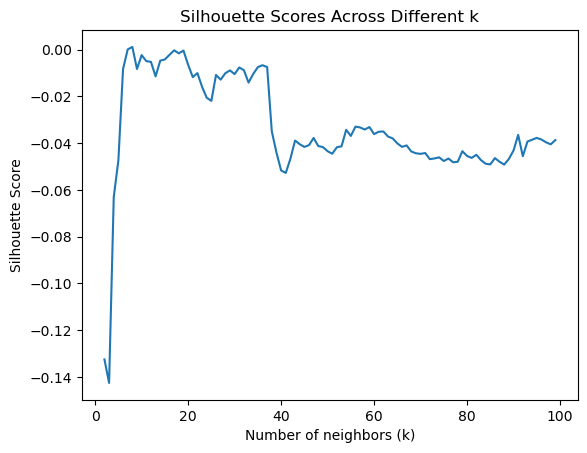

In [28]:
from sklearn.metrics import silhouette_score

scores = []
ks = range(2, 100)  # Adjusted range of k values to test

for k in ks:
    mydmap = dm.DiffusionMap.from_sklearn(alpha=alpha, k=k, n_evecs=10, epsilon='bgh')
    X_embedded = mydmap.fit_transform(X_normalized_l2)
    X_embedded = clean_embedding(X_embedded)  # Clean each embedding
    
    try:
        if X_embedded.shape[1] > 1:  # Ensure at least 2 dimensions are returned
            score = silhouette_score(X_embedded, true_labels)
            scores.append(score)
        else:
            scores.append(-1)  # Handling cases where not enough dimensions are returned
    except ValueError as e:
        print(f"Error computing silhouette score for k={k}: {e}")
        scores.append(-1)

# Plot results
plt.plot(ks, scores)
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores Across Different k')
plt.show()


In [29]:
max_index = np.argmax(scores)  # returns the index of the maximum value in scores list

# Find the optimal k corresponding to the maximum score
optimal_k = ks[max_index]
max_score = scores[max_index]
print(optimal_k)

8


In [30]:
mydmap = dm.DiffusionMap.from_sklearn(alpha=alpha, k=optimal_k, n_evecs=10, epsilon='bgh')
X_embedded = mydmap.fit_transform(X_normalized_l2)
X_embedded = clean_embedding(X_embedded)

In [31]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import confusion_matrix

L = len(set(true_labels))  # Number of unique labels
for K in range(L, 2 * L + 1):
    kmeans = KMeans(n_clusters=K)
    clusters = kmeans.fit_predict(X_embedded)
    print(f"Clustering with K={K} clusters done.")
    conf_matrix = confusion_matrix(true_labels, clusters)
    print("Confusion Matrix:\n", conf_matrix)

Clustering with K=8 clusters done.
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0]
 [ 11   0   0  38   0   0   0   5   0]
 [  6  61   0  47   5   0   2   0   0]
 [ 20   1   1  49   0   1   0   0   0]
 [ 56   0   0  63  10   8   0   0   0]
 [ 96   2   0 106   0   1   0   0   0]
 [ 13   9   0  36   0   0   1   1   0]
 [242   0   5  30   0   3   0   0   0]
 [ 53   3   0  54   0   0   8   0   0]]
Clustering with K=9 clusters done.
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0]
 [  0  11   0  38   0   0   0   5   0]
 [  0   5   0  51  58   5   2   0   0]
 [  0  20   1  49   1   0   0   0   1]
 [  4  52   0  70   0  10   0   0   1]
 [ 13  92   0  97   2   0   0   0   1]
 [  0  12   0  37   9   0   1   1   0]
 [  1 241   5  30   0   0   0   0   3]
 [  0  52   0  55   3   0   8   0   0]]
Clustering with K=10 clusters done.
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0   0]
 [ 10   1   0   0   0   0  38   0   5   0]
 [  5  21   0   2   5   0  26  62   0   0]
 [ 1

In [32]:
for K in range(L, 2 * L + 1):
    kmeans = KMeans(n_clusters=K)
    clusters = kmeans.fit_predict(X_normalized_l2)
    print(f"Clustering with K={K} clusters done.")
    conf_matrix = confusion_matrix(true_labels, clusters)
    print("Confusion Matrix:\n", conf_matrix)

Clustering with K=8 clusters done.
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0]
 [ 11  12   3   8   4   0   4  12   0]
 [  0  13   6  10  19  16   9  48   0]
 [  5  23   7   3   5   0   3  26   0]
 [  0  12  13  69   5   1   5  32   0]
 [  1  23  32  30  11   3  20  85   0]
 [  0  29   2   9   9   3   1   7   0]
 [ 10  40  31  36  26   6   8 123   0]
 [  1  19  11  14  27  13   4  29   0]]
Clustering with K=9 clusters done.
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0]
 [ 28   2   2   8   2   3   3   6   0]
 [ 47   1   6   1  23  28   4   2   9]
 [ 35   9   3   4  11   2   4   4   0]
 [ 40   9   8  18  21  17  12  12   0]
 [ 96  13   5  20  13  25  16  17   0]
 [ 14   1   1   1   4   4  31   4   0]
 [153  13  10  24  16  25  24  15   0]
 [ 36   3  11   1   4   5  16  39   3]]
Clustering with K=10 clusters done.
Confusion Matrix:
 [[ 0  0  0  0  0  0  0  0  0  0]
 [18  1  4 14  1  5  0  6  2  3]
 [ 0  1 33 35  4 24  1 12  2  9]
 [ 4  3  2  5  5  8  0 18 22  5]
 

In [33]:
for K in range(L, 2 * L + 1):
    kmeans = KMeans(n_clusters=K)
    clusters = kmeans.fit_predict(X_normalized_l1)
    print(f"Clustering with K={K} clusters done.")
    conf_matrix = confusion_matrix(true_labels, clusters)
    print("Confusion Matrix:\n", conf_matrix)

Clustering with K=8 clusters done.
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  54   0   0   0]
 [  0   0   1   1   0 119   0   0   0]
 [  0   0   0   0   1  71   0   0   0]
 [  2   0   0   2   0 133   0   0   0]
 [  1   0   0   0   0 203   1   0   0]
 [  0   0   0   0   0  60   0   0   0]
 [  0   5   0   0   1 271   0   3   0]
 [  0   0   0   0   0 118   0   0   0]]
Clustering with K=9 clusters done.
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0]
 [  0   0   0  54   0   0   0   0   0]
 [  0   0   0 119   0   0   1   1   0]
 [  0   0   0  71   0   1   0   0   0]
 [  0   0   0 136   0   0   0   0   1]
 [  0   0   0 203   0   0   0   0   2]
 [  0   0   0  60   0   0   0   0   0]
 [  0   1   9 263   5   2   0   0   0]
 [  2   0   1 113   0   0   0   2   0]]
Clustering with K=10 clusters done.
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0   0]
 [  0  54   0   0   0   0   0   0   0   0]
 [  0 119   0   0   0   1   0   0   0   1]
 [  

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import numpy as np

# Initialize TF-IDF Vectorizer with English stop words
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(documents)


num_components = 10  
lsi_model = TruncatedSVD(n_components=num_components)

# Transform the TF-IDF matrix using LSI
X_lsi = lsi_model.fit_transform(X_tfidf)

# Normalize the LSI transformed data
X_lsi_normalized = normalize(X_lsi, norm='l2')

print("LSI Components Shape:", X_lsi.shape)



LSI Components Shape: (1047, 10)


In [61]:
for K in range(L, 2 * L + 1):
    kmeans = KMeans(n_clusters=K)
    clusters = kmeans.fit_predict(X_lsi_normalized)
    print(f"Clustering with K={K} clusters done.")
    conf_matrix = confusion_matrix(true_labels, clusters)
    print("Confusion Matrix:\n", conf_matrix)

Clustering with K=8 clusters done.
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0]
 [  0   2   0   0   0   5   0  47   0]
 [  0   0  22  50   0  48   0   1   0]
 [  0  46   0   0   2   4   1  19   0]
 [ 16   3   0   0   0  33   0  85   0]
 [  0  12   0   0   5  23  49 116   0]
 [  0   2   0   0   1  51   0   6   0]
 [  0  89   0   0  87   3  65  36   0]
 [  2   0   0   2   0 101   2  11   0]]
Clustering with K=9 clusters done.
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0]
 [  0   0   0  20   4   0   0  30   0]
 [  0  55   0   3  13   0   0   4  46]
 [  0   0   0   0   0   1   1  70   0]
 [  1   4   0  18  76   0   0  38   0]
 [  4   1   0  51   8   9  18 114   0]
 [  2   0   0   5   2   1   0  50   0]
 [ 33   0  29   7   1  46  83  81   0]
 [  0   1   0  89   2   0   1  23   2]]
Clustering with K=10 clusters done.
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0   0]
 [  0   4  47   0   0   1   0   1   0   1]
 [  0   0   9   0  48   1   0  63   0   0]
 [  

In [95]:
# Clustering with exactly L clusters
#kmeans = KMeans(n_clusters=L)
#clusters_lsi = kmeans.fit_predict(X_lsi_normalized)

#def find_representative_words(X, clusters, vectorizer, num_words=5):
    #features = vectorizer.get_feature_names_out()
    #for k in range(np.max(clusters) + 1):
        #cluster_center = X[clusters == k].mean(axis=0)
        #top_indices = cluster_center.argsort()[-num_words:][::-1]
        #print(f"Cluster {k}: {[features[i] for i in top_indices]}")

#find_representative_words(X_lsi_normalized, clusters_lsi, tfidf_vectorizer)


In [93]:
kmeans = KMeans(n_clusters=L)
clusters = kmeans.fit_predict(X_normalized_l2)

def find_representative_words(X, clusters, vectorizer, num_words=5):
    features = np.array(vectorizer.get_feature_names_out())
    #print("Features type check:", type(features[0]))  # Should print: <class 'str'>

    for k in range(np.max(clusters) + 1):
        # Calculate mean of points in cluster
        cluster_center = X[clusters == k].mean(axis=0)
        # Find indices of the top words
        top_indices = cluster_center.argsort()[-num_words:][::-1]
        # Extract top features using indices
        top_features = [features[i] for i in top_indices]
        # Convert all features to string (if not already)
        top_features = [str(feature) for feature in top_features]
        #print("Top features type check:", type(top_features[0]))  # Should print: <class 'str'>
        print(f"Cluster {k}: ", ", ".join(top_features))

# Ensure X_normalized_l2 and clusters are correctly formatted and run the function
find_representative_words(X_normalized_l2, clusters, vectorizer)

Cluster 0:  ecology, features, fred, conventionally, glycine
Cluster 1:  aquifers, historically, disservice, bothered, huge
Cluster 2:  assigning, favors, discover, fax, biased
Cluster 3:  coauthored, ask, common, dam, 285
Cluster 4:  assay, glycoprotein, detecting, antonio, blends
Cluster 5:  hydroxyl, inhaled, displaced, hyena, imparted
Cluster 6:  changeable, interdisciplinary, easily, astonishing, danger
Cluster 7:  frontier, calculations, echoed, 30, browning


In [94]:
kmeans = KMeans(n_clusters=L)
clusters = kmeans.fit_predict(X_normalized_l1)
#clusters = kmeans.fit_predict(X_embedded)

def find_representative_words(X, clusters, vectorizer, num_words=5):
    features = np.array(vectorizer.get_feature_names_out())
    #print("Features type check:", type(features[0]))  # Should print: <class 'str'>

    for k in range(np.max(clusters) + 1):
        # Calculate mean of points in cluster
        cluster_center = X[clusters == k].mean(axis=0)
        # Find indices of the top words
        top_indices = cluster_center.argsort()[-num_words:][::-1]
        # Extract top features using indices
        top_features = [features[i] for i in top_indices]
        # Convert all features to string (if not already)
        top_features = [str(feature) for feature in top_features]
        #print("Top features type check:", type(top_features[0]))  # Should print: <class 'str'>
        print(f"Cluster {k}: ", ", ".join(top_features))

find_representative_words(X_normalized_l1, clusters, vectorizer)
#find_representative_words(X_embedded, clusters, vectorizer)

Cluster 0:  changeable, assay, coauthored, epa, ask
Cluster 1:  diverge, bite, interbred, irrational, chess
Cluster 2:  echoed, brakes, abdominal, drum, benefit
Cluster 3:  imposed, annals, 1972, gifts, great
Cluster 4:  ecology, hyena, implants, hydroxyl, interfering
Cluster 5:  hydroxyl, hyena, elicit, cambridge, implanting
Cluster 6:  countryside, country, alters, extinctions, diagonal
Cluster 7:  defending, dangers, acceptable, developing, furnished


In [92]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X_normalized_l2, true_labels, test_size=0.25, random_state=42)  # Adjust sizes accordingly

# Linear kernel SVM
clf_linear = svm.SVC(kernel='linear')
clf_linear.fit(X_train, y_train)



# Testing and evaluating the classifier
y_pred_linear = clf_linear.predict(X_test)


print("Linear Kernel Results:")
print(confusion_matrix(y_test, y_pred_linear))
print(classification_report(y_test, y_pred_linear))

cm = confusion_matrix(y_test, y_pred_linear)  # confusion matrix

FP = cm.sum(axis=0) - np.diag(cm)  # Sum each column, subtract diagonal (True Positives)
FN = cm.sum(axis=1) - np.diag(cm)  # Sum each row, subtract diagonal (True Positives)

Type_I_Error = FP / cm.sum(axis=0)  # False Positives Ratio for each class
Type_II_Error = FN / cm.sum(axis=1)  # False Negatives Ratio for each class

print("Type I Errors for each class:", Type_I_Error)
print("Type II Errors for each class:", Type_II_Error)


Linear Kernel Results:
[[ 0  0  0  2  1  0  4  1]
 [ 0 13  0  0  0  0 10  2]
 [ 0  1  3  0  1  0 16  0]
 [ 0  2  0 15  6  0 11  1]
 [ 0  1  0  2 32  0 18  0]
 [ 0  1  0  0  2  3  6  0]
 [ 0  0  0  0  4  0 68  1]
 [ 0  0  0  3  2  1 18 11]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.72      0.52      0.60        25
           3       1.00      0.14      0.25        21
           4       0.68      0.43      0.53        35
           5       0.67      0.60      0.63        53
           6       0.75      0.25      0.38        12
           7       0.45      0.93      0.61        73
           8       0.69      0.31      0.43        35

    accuracy                           0.55       262
   macro avg       0.62      0.40      0.43       262
weighted avg       0.63      0.55      0.52       262

Type I Errors for each class: [       nan 0.27777778 0.         0.31818182 0.33333333 0.25
 0.54966887 0.3125

/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/fo

In [97]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X_normalized_l2, true_labels, test_size=0.25, random_state=12)  # Adjust sizes accordingly

# Linear kernel SVM
clf_linear = svm.SVC(kernel='linear')
clf_linear.fit(X_train, y_train)



# Testing and evaluating the classifier
y_pred_linear = clf_linear.predict(X_test)


print("Linear Kernel Results:")
print(confusion_matrix(y_test, y_pred_linear))
print(classification_report(y_test, y_pred_linear))

cm = confusion_matrix(y_test, y_pred_linear)  # confusion matrix

FP = cm.sum(axis=0) - np.diag(cm)  # Sum each column, subtract diagonal (True Positives)
FN = cm.sum(axis=1) - np.diag(cm)  # Sum each row, subtract diagonal (True Positives)

Type_I_Error = FP / cm.sum(axis=0)  # False Positives Ratio for each class
Type_II_Error = FN / cm.sum(axis=1)  # False Negatives Ratio for each class

print("Type I Errors for each class:", Type_I_Error)
print("Type II Errors for each class:", Type_II_Error)

Linear Kernel Results:
[[ 4  0  0  0  2  0  6  0]
 [ 0 17  0  0  2  0  7  2]
 [ 0  0  4  0  6  0 16  0]
 [ 0  2  0 18  5  0  9  1]
 [ 2  0  0  4 36  0 17  1]
 [ 0  1  0  0  3  2  6  1]
 [ 0  0  0  0  1  0 64  0]
 [ 0  0  0  3  3  0  6 11]]
              precision    recall  f1-score   support

           1       0.67      0.33      0.44        12
           2       0.85      0.61      0.71        28
           3       1.00      0.15      0.27        26
           4       0.72      0.51      0.60        35
           5       0.62      0.60      0.61        60
           6       1.00      0.15      0.27        13
           7       0.49      0.98      0.65        65
           8       0.69      0.48      0.56        23

    accuracy                           0.60       262
   macro avg       0.75      0.48      0.51       262
weighted avg       0.69      0.60      0.57       262

Type I Errors for each class: [0.33333333 0.15       0.         0.28       0.37931034 0.
 0.51145038 0.3125  

In [102]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X_normalized_l2, true_labels, test_size=0.25, random_state=30)  # Adjust sizes accordingly

# Linear kernel SVM
clf_linear = svm.SVC(kernel='linear')
clf_linear.fit(X_train, y_train)



# Testing and evaluating the classifier
y_pred_linear = clf_linear.predict(X_test)


print("Linear Kernel Results:")
print(confusion_matrix(y_test, y_pred_linear))
print(classification_report(y_test, y_pred_linear))

cm = confusion_matrix(y_test, y_pred_linear)  # confusion matrix

FP = cm.sum(axis=0) - np.diag(cm)  # Sum each column, subtract diagonal (True Positives)
FN = cm.sum(axis=1) - np.diag(cm)  # Sum each row, subtract diagonal (True Positives)

Type_I_Error = FP / cm.sum(axis=0)  # False Positives Ratio for each class
Type_II_Error = FN / cm.sum(axis=1)  # False Negatives Ratio for each class

print("Type I Errors for each class:", Type_I_Error)
print("Type II Errors for each class:", Type_II_Error)

Linear Kernel Results:
[[ 3  0  2  1  2  0  6  0]
 [ 0 18  0  1  0  0  7  0]
 [ 0  0  4  0  3  0  7  0]
 [ 0  2  0 13  9  0  9  1]
 [ 0  0  0  0 37  0 22  0]
 [ 0  0  1  0  2  2  9  3]
 [ 0  0  0  3  1  0 69  1]
 [ 0  1  0  0  0  1 11 11]]
              precision    recall  f1-score   support

           1       1.00      0.21      0.35        14
           2       0.86      0.69      0.77        26
           3       0.57      0.29      0.38        14
           4       0.72      0.38      0.50        34
           5       0.69      0.63      0.65        59
           6       0.67      0.12      0.20        17
           7       0.49      0.93      0.64        74
           8       0.69      0.46      0.55        24

    accuracy                           0.60       262
   macro avg       0.71      0.46      0.51       262
weighted avg       0.66      0.60      0.57       262

Type I Errors for each class: [0.         0.14285714 0.42857143 0.27777778 0.31481481 0.33333333
 0.50714286 

In [90]:

X_train_lsi, X_test_lsi, y_train_lsi, y_test_lsi = train_test_split(X_lsi_normalized, true_labels, test_size=0.25, random_state=42)


clf_linear_lsi = svm.SVC(kernel='linear')
clf_linear_lsi.fit(X_train_lsi, y_train_lsi)
y_pred_linear_lsi = clf_linear_lsi.predict(X_test_lsi)

print("Diffusion Space Linear Kernel Results:")
print(confusion_matrix(y_test_lsi, y_pred_linear_lsi))
print(classification_report(y_test_lsi, y_pred_linear_lsi))


cm = confusion_matrix(y_test_lsi, y_pred_linear_lsi)  # confusion matrix

FP = cm.sum(axis=0) - np.diag(cm)  # Sum each column, subtract diagonal (True Positives)
FN = cm.sum(axis=1) - np.diag(cm)  # Sum each row, subtract diagonal (True Positives)

Type_I_Error = FP / cm.sum(axis=0)  # False Positives Ratio for each class
Type_II_Error = FN / cm.sum(axis=1)  # False Negatives Ratio for each class

print("Type I Errors for each class:", Type_I_Error)
print("Type II Errors for each class:", Type_II_Error)


Diffusion Space Linear Kernel Results:
[[ 0  0  0  3  4  0  1  0]
 [ 0 23  0  1  0  0  0  1]
 [ 0  0 17  1  1  1  1  0]
 [ 0  7  0 22  6  0  0  0]
 [ 0  0  1  6 33  3 10  0]
 [ 0  0  0  0  1  9  0  2]
 [ 0  0  1  0  1  0 71  0]
 [ 0  0  0  2  2  2  1 28]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.77      0.92      0.84        25
           3       0.89      0.81      0.85        21
           4       0.63      0.63      0.63        35
           5       0.69      0.62      0.65        53
           6       0.60      0.75      0.67        12
           7       0.85      0.97      0.90        73
           8       0.90      0.80      0.85        35

    accuracy                           0.77       262
   macro avg       0.67      0.69      0.67       262
weighted avg       0.75      0.77      0.76       262

Type I Errors for each class: [       nan 0.23333333 0.10526316 0.37142857 0.3125     0.4
 0.

/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/fo

In [98]:
X_train_lsi, X_test_lsi, y_train_lsi, y_test_lsi = train_test_split(X_lsi_normalized, true_labels, test_size=0.25, random_state=12)


clf_linear_lsi = svm.SVC(kernel='linear')
clf_linear_lsi.fit(X_train_lsi, y_train_lsi)
y_pred_linear_lsi = clf_linear_lsi.predict(X_test_lsi)

print("Diffusion Space Linear Kernel Results:")
print(confusion_matrix(y_test_lsi, y_pred_linear_lsi))
print(classification_report(y_test_lsi, y_pred_linear_lsi))


cm = confusion_matrix(y_test_lsi, y_pred_linear_lsi)  # confusion matrix

FP = cm.sum(axis=0) - np.diag(cm)  # Sum each column, subtract diagonal (True Positives)
FN = cm.sum(axis=1) - np.diag(cm)  # Sum each row, subtract diagonal (True Positives)

Type_I_Error = FP / cm.sum(axis=0)  # False Positives Ratio for each class
Type_II_Error = FN / cm.sum(axis=1)  # False Negatives Ratio for each class

print("Type I Errors for each class:", Type_I_Error)
print("Type II Errors for each class:", Type_II_Error)

Diffusion Space Linear Kernel Results:
[[ 0  1  1  1  8  1  0  0]
 [ 0 27  0  0  0  0  0  1]
 [ 0  0 19  0  2  2  2  1]
 [ 0  4  1 18  7  0  3  2]
 [ 0  1  0  6 38  5  8  2]
 [ 0  0  1  1  0 10  0  1]
 [ 0  0  0  0  1  0 64  0]
 [ 0  2  0  2  0  1  1 17]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        12
           2       0.77      0.96      0.86        28
           3       0.86      0.73      0.79        26
           4       0.64      0.51      0.57        35
           5       0.68      0.63      0.66        60
           6       0.53      0.77      0.62        13
           7       0.82      0.98      0.90        65
           8       0.71      0.74      0.72        23

    accuracy                           0.74       262
   macro avg       0.63      0.67      0.64       262
weighted avg       0.70      0.74      0.71       262

Type I Errors for each class: [       nan 0.22857143 0.13636364 0.35714286 0.32142857 0.47368

/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/fo

In [101]:
X_train_lsi, X_test_lsi, y_train_lsi, y_test_lsi = train_test_split(X_lsi_normalized, true_labels, test_size=0.25, random_state=30)


clf_linear_lsi = svm.SVC(kernel='linear')
clf_linear_lsi.fit(X_train_lsi, y_train_lsi)
y_pred_linear_lsi = clf_linear_lsi.predict(X_test_lsi)

print("Diffusion Space Linear Kernel Results:")
print(confusion_matrix(y_test_lsi, y_pred_linear_lsi))
print(classification_report(y_test_lsi, y_pred_linear_lsi))


cm = confusion_matrix(y_test_lsi, y_pred_linear_lsi)  # confusion matrix

FP = cm.sum(axis=0) - np.diag(cm)  # Sum each column, subtract diagonal (True Positives)
FN = cm.sum(axis=1) - np.diag(cm)  # Sum each row, subtract diagonal (True Positives)

Type_I_Error = FP / cm.sum(axis=0)  # False Positives Ratio for each class
Type_II_Error = FN / cm.sum(axis=1)  # False Negatives Ratio for each class

print("Type I Errors for each class:", Type_I_Error)
print("Type II Errors for each class:", Type_II_Error)

Diffusion Space Linear Kernel Results:
[[ 0  1  3  1  7  0  2  0]
 [ 0 25  0  1  0  0  0  0]
 [ 0  0  9  0  0  5  0  0]
 [ 0  3  2 24  2  0  2  1]
 [ 0  1  1  0 38  8 11  0]
 [ 0  0  0  0  0 16  0  1]
 [ 0  0  2  2  0  0 69  1]
 [ 0  3  0  0  0  1  0 20]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.76      0.96      0.85        26
           3       0.53      0.64      0.58        14
           4       0.86      0.71      0.77        34
           5       0.81      0.64      0.72        59
           6       0.53      0.94      0.68        17
           7       0.82      0.93      0.87        74
           8       0.87      0.83      0.85        24

    accuracy                           0.77       262
   macro avg       0.65      0.71      0.67       262
weighted avg       0.74      0.77      0.75       262

Type I Errors for each class: [       nan 0.24242424 0.47058824 0.14285714 0.19148936 0.46666

/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/fo

In [91]:

X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(X_embedded, true_labels, test_size=0.25, random_state=42)


clf_linear_emb = svm.SVC(kernel='linear')
clf_linear_emb.fit(X_train_emb, y_train_emb)
y_pred_linear_emb = clf_linear_emb.predict(X_test_emb)

print("Diffusion Space Linear Kernel Results:")
print(confusion_matrix(y_test_emb, y_pred_linear_emb))
print(classification_report(y_test_emb, y_pred_linear_emb))

cm = confusion_matrix(y_test_emb, y_pred_linear_emb)  # confusion matrix

FP = cm.sum(axis=0) - np.diag(cm)  # Sum each column, subtract diagonal (True Positives)
FN = cm.sum(axis=1) - np.diag(cm)  # Sum each row, subtract diagonal (True Positives)

Type_I_Error = FP / cm.sum(axis=0)  # False Positives Ratio for each class
Type_II_Error = FN / cm.sum(axis=1)  # False Negatives Ratio for each class

print("Type I Errors for each class:", Type_I_Error)
print("Type II Errors for each class:", Type_II_Error)

Diffusion Space Linear Kernel Results:
[[ 0  0  0  0  1  0  7  0]
 [ 0 18  0  1  2  0  2  2]
 [ 0  0  0  0  0  0 21  0]
 [ 0  0  0  6  8  0 21  0]
 [ 0  1  0  0  8  0 44  0]
 [ 0  1  0  0  1  0 10  0]
 [ 0  0  0  0  0  0 73  0]
 [ 0  0  0  0  1  0 33  1]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.90      0.72      0.80        25
           3       0.00      0.00      0.00        21
           4       0.86      0.17      0.29        35
           5       0.38      0.15      0.22        53
           6       0.00      0.00      0.00        12
           7       0.35      1.00      0.51        73
           8       0.33      0.03      0.05        35

    accuracy                           0.40       262
   macro avg       0.35      0.26      0.23       262
weighted avg       0.42      0.40      0.31       262

Type I Errors for each class: [       nan 0.1               nan 0.14285714 0.61904762        

/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/fo

In [99]:
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(X_embedded, true_labels, test_size=0.25, random_state=12)


clf_linear_emb = svm.SVC(kernel='linear')
clf_linear_emb.fit(X_train_emb, y_train_emb)
y_pred_linear_emb = clf_linear_emb.predict(X_test_emb)

print("Diffusion Space Linear Kernel Results:")
print(confusion_matrix(y_test_emb, y_pred_linear_emb))
print(classification_report(y_test_emb, y_pred_linear_emb))

cm = confusion_matrix(y_test_emb, y_pred_linear_emb)  # confusion matrix

FP = cm.sum(axis=0) - np.diag(cm)  # Sum each column, subtract diagonal (True Positives)
FN = cm.sum(axis=1) - np.diag(cm)  # Sum each row, subtract diagonal (True Positives)

Type_I_Error = FP / cm.sum(axis=0)  # False Positives Ratio for each class
Type_II_Error = FN / cm.sum(axis=1)  # False Negatives Ratio for each class

print("Type I Errors for each class:", Type_I_Error)
print("Type II Errors for each class:", Type_II_Error)

Diffusion Space Linear Kernel Results:
[[ 0  0  0  0  0  0 12  0]
 [ 0 19  0  0  3  0  6  0]
 [ 0  0  0  0  1  0 25  0]
 [ 0  0  0  8  5  0 22  0]
 [ 0  0  0  0  8  0 52  0]
 [ 0  2  0  0  0  0 11  0]
 [ 0  0  0  0  0  0 65  0]
 [ 0  1  0  0  2  0 18  2]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        12
           2       0.86      0.68      0.76        28
           3       0.00      0.00      0.00        26
           4       1.00      0.23      0.37        35
           5       0.42      0.13      0.20        60
           6       0.00      0.00      0.00        13
           7       0.31      1.00      0.47        65
           8       1.00      0.09      0.16        23

    accuracy                           0.39       262
   macro avg       0.45      0.27      0.25       262
weighted avg       0.49      0.39      0.31       262

Type I Errors for each class: [       nan 0.13636364        nan 0.         0.57894737        

/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/fo

In [100]:
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(X_embedded, true_labels, test_size=0.25, random_state=30)


clf_linear_emb = svm.SVC(kernel='linear')
clf_linear_emb.fit(X_train_emb, y_train_emb)
y_pred_linear_emb = clf_linear_emb.predict(X_test_emb)

print("Diffusion Space Linear Kernel Results:")
print(confusion_matrix(y_test_emb, y_pred_linear_emb))
print(classification_report(y_test_emb, y_pred_linear_emb))

cm = confusion_matrix(y_test_emb, y_pred_linear_emb)  # confusion matrix

FP = cm.sum(axis=0) - np.diag(cm)  # Sum each column, subtract diagonal (True Positives)
FN = cm.sum(axis=1) - np.diag(cm)  # Sum each row, subtract diagonal (True Positives)

Type_I_Error = FP / cm.sum(axis=0)  # False Positives Ratio for each class
Type_II_Error = FN / cm.sum(axis=1)  # False Negatives Ratio for each class

print("Type I Errors for each class:", Type_I_Error)
print("Type II Errors for each class:", Type_II_Error)

Diffusion Space Linear Kernel Results:
[[ 0  0  0  0  0  0 14  0]
 [ 0 19  0  1  1  0  5  0]
 [ 0  0  0  0  1  0 13  0]
 [ 0  0  0  3  6  0 25  0]
 [ 0  0  0  0  8  0 51  0]
 [ 0  0  0  0  0  0 17  0]
 [ 0  0  0  0  0  0 74  0]
 [ 0  1  0  0  2  0 18  3]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.95      0.73      0.83        26
           3       0.00      0.00      0.00        14
           4       0.75      0.09      0.16        34
           5       0.44      0.14      0.21        59
           6       0.00      0.00      0.00        17
           7       0.34      1.00      0.51        74
           8       1.00      0.12      0.22        24

    accuracy                           0.41       262
   macro avg       0.44      0.26      0.24       262
weighted avg       0.48      0.41      0.31       262

Type I Errors for each class: [       nan 0.05              nan 0.25       0.55555556        

/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daiziheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/fo